In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
from glob import glob
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import io
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from keras import layers, optimizers
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import keras.backend as K

from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input,MaxPooling2D, concatenate, UpSampling2D
from keras.applications import VGG19

from warnings import filterwarnings
from skimage import io

In [ ]:
data = pd.read_csv('/content/drive/My Drive/590/kaggle_3m/data.csv')
data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [ ]:
import os
data_map = []
for sub_dir_path in glob("/content/drive/My Drive/590/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)


[Errno 20] Not a directory: '/content/drive/My Drive/590/kaggle_3m/README.md'
[Errno 20] Not a directory: '/content/drive/My Drive/590/kaggle_3m/data.csv'


In [ ]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...
1,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...
2,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...
3,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...
4,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...


In [ ]:
original_img = df[~df['path'].str.contains("mask")]
mask_img = df[df['path'].str.contains("mask")]

In [ ]:
original_img, mask_img

(                 patient_id                                               path
 3     TCGA_DU_7010_19860307  /content/drive/My Drive/590/kaggle_3m/TCGA_DU_...
 4     TCGA_DU_7010_19860307  /content/drive/My Drive/590/kaggle_3m/TCGA_DU_...
 5     TCGA_DU_7010_19860307  /content/drive/My Drive/590/kaggle_3m/TCGA_DU_...
 7     TCGA_DU_7010_19860307  /content/drive/My Drive/590/kaggle_3m/TCGA_DU_...
 8     TCGA_DU_7010_19860307  /content/drive/My Drive/590/kaggle_3m/TCGA_DU_...
 ...                     ...                                                ...
 7873  TCGA_FG_A60K_20040224  /content/drive/My Drive/590/kaggle_3m/TCGA_FG_...
 7874  TCGA_FG_A60K_20040224  /content/drive/My Drive/590/kaggle_3m/TCGA_FG_...
 7877  TCGA_FG_A60K_20040224  /content/drive/My Drive/590/kaggle_3m/TCGA_FG_...
 7878  TCGA_FG_A60K_20040224  /content/drive/My Drive/590/kaggle_3m/TCGA_FG_...
 7880  TCGA_FG_A60K_20040224  /content/drive/My Drive/590/kaggle_3m/TCGA_FG_...
 
 [3944 rows x 2 columns],
            

In [ ]:
len(original_img['path'].values[0])

88

In [ ]:
# File path line length images for later sorting
BASE_LEN = 82 #len('/content/drive/My Drive/590/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_1)
END_IMG_LEN = 4 
END_MASK_LEN = 9 

In [ ]:
original_img = original_img[~original_img['path'].str.contains("\(")]
mask_img = mask_img[~mask_img['path'].str.contains("\(")]

imgs = sorted(original_img["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(mask_img["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Image path:", imgs[idx], "\nMask path:", masks[idx])

Image path: /content/drive/My Drive/590/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_12.tif 
Mask path: /content/drive/My Drive/590/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_12_mask.tif


In [ ]:
mri_df = pd.DataFrame({"patient_id": original_img.patient_id.values,"img_path": imgs,
                           'mask_path':masks})
mri_df

,patient_id,img_path,mask_path
0,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...
1,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...
2,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...
3,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...
4,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...
...,...,...,...
3924,TCGA_FG_A60K_20040224,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...
3925,TCGA_FG_A60K_20040224,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...
3926,TCGA_FG_A60K_20040224,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...
3927,TCGA_FG_A60K_20040224,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...


In [ ]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": original_img.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...,0
1,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...,0
2,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,0
3,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...,0
4,TCGA_DU_7010_19860307,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...,/content/drive/My Drive/590/kaggle_3m/TCGA_DU_...,0
...,...,...,...,...
3924,TCGA_FG_A60K_20040224,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,0
3925,TCGA_FG_A60K_20040224,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,0
3926,TCGA_FG_A60K_20040224,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,0
3927,TCGA_FG_A60K_20040224,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,/content/drive/My Drive/590/kaggle_3m/TCGA_HT_...,0


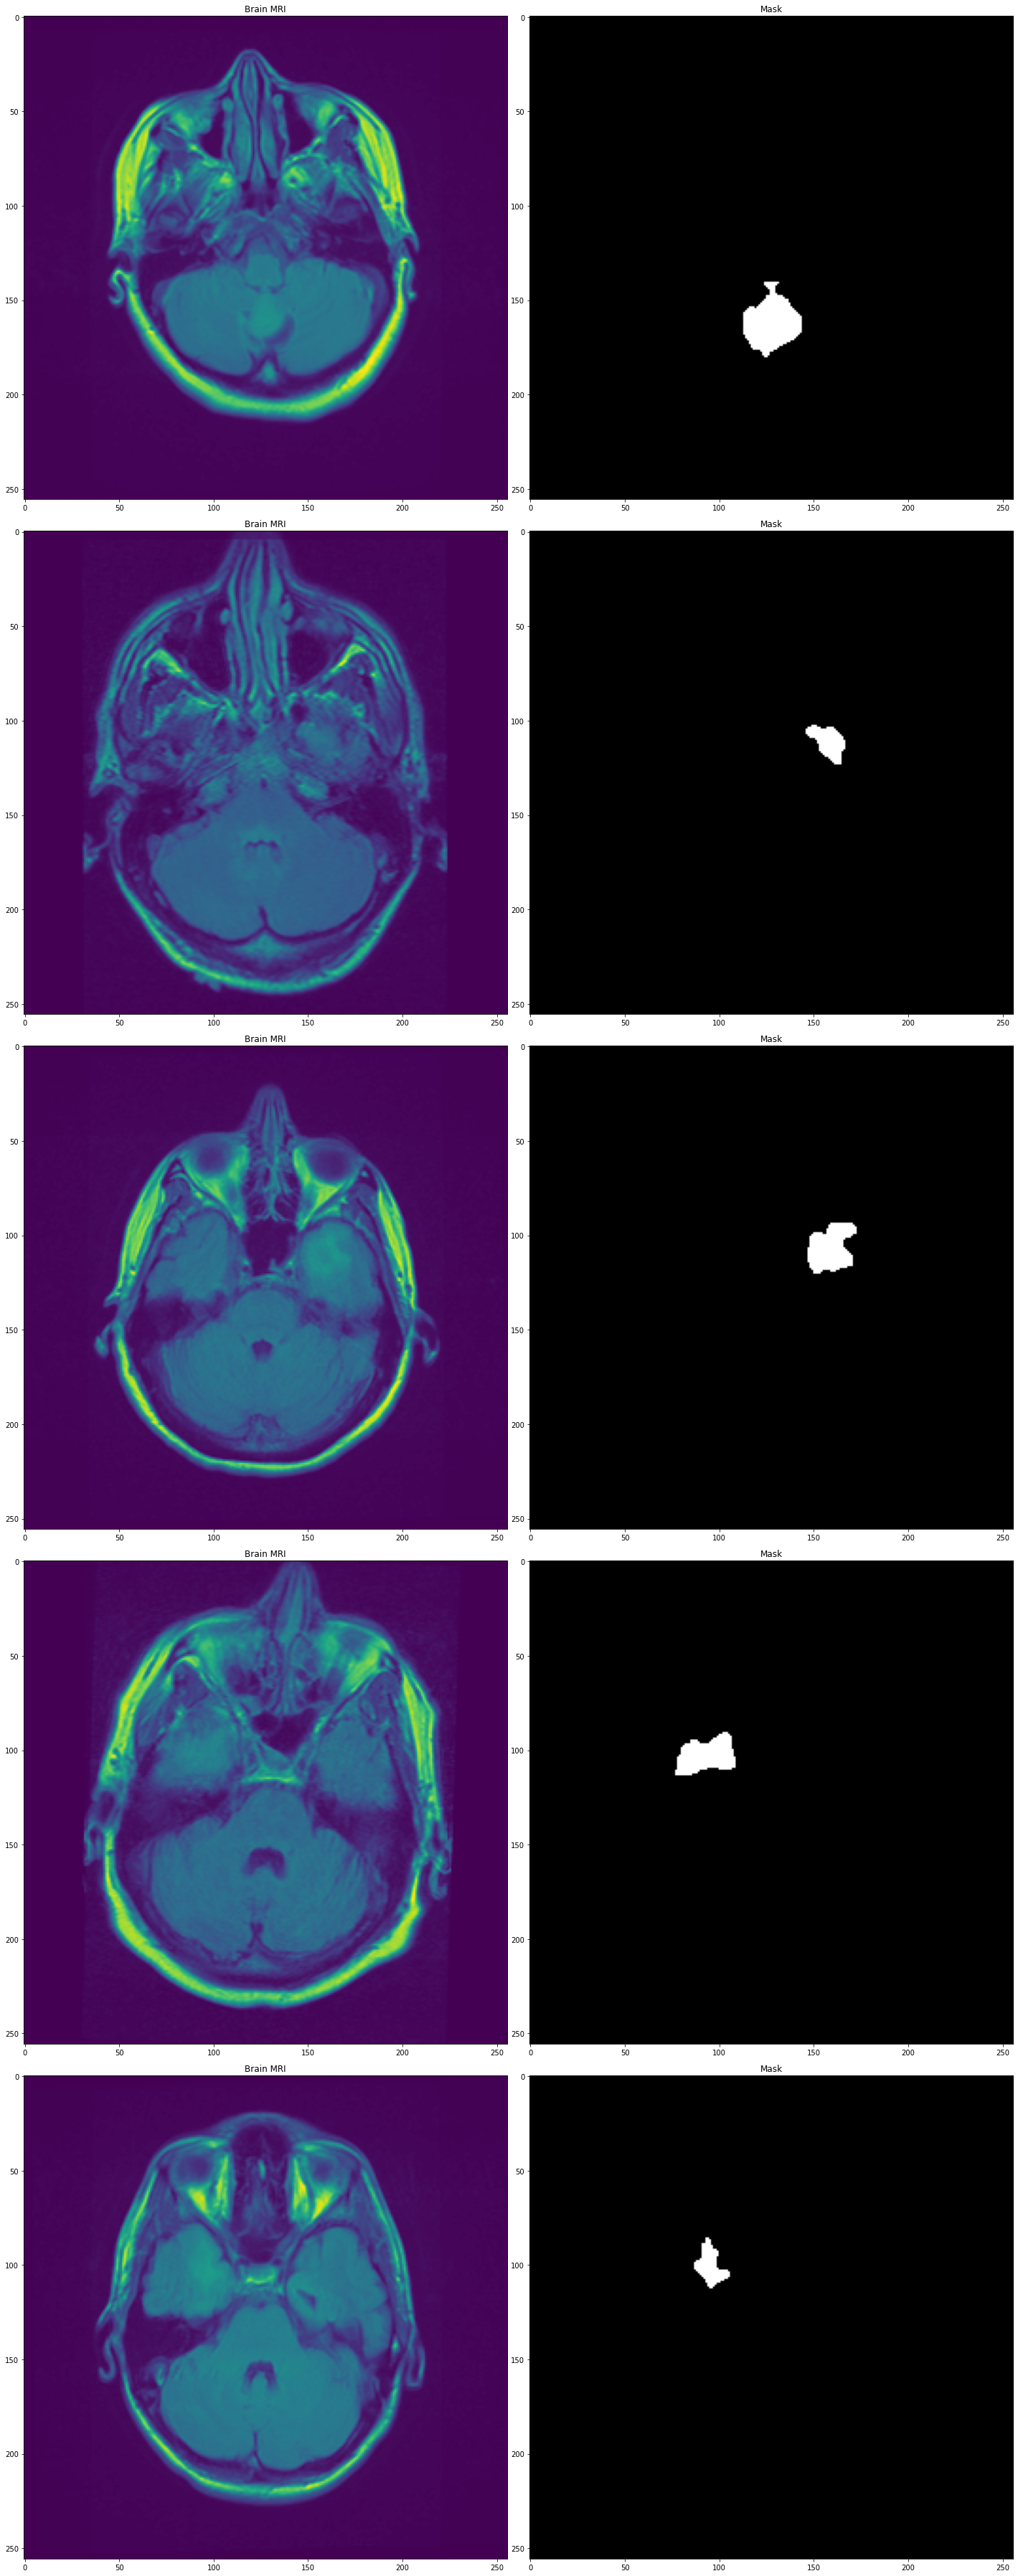

In [ ]:
count = 0
i = 0
fig,axs = plt.subplots(5,2, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = cv2.imread(brain_df.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = cv2.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        count +=1
    i += 1
    if (count==5):
        break
        
fig.tight_layout()

In [ ]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)


Train size is 1167, valid size is 103 & test size is 103


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)
    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)



In [ ]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    bn_1 = BatchNormalization(axis=3)(conv1)
    act_1 = Activation('relu')(bn_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act_1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    bn_2 = BatchNormalization(axis=3)(conv2)
    act_2 = Activation('relu')(bn_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act_2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    bn_3 = BatchNormalization(axis=3)(conv3)
    act_3 = Activation('relu')(bn_3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act_3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    bn_4 = BatchNormalization(axis=3)(conv4)
    act_4 = Activation('relu')(bn_4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(act_4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    bn_5 = BatchNormalization(axis=3)(conv5)
    act_5 = Activation('relu')(bn_5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    bn_6 = BatchNormalization(axis=3)(conv6)
    act_6 = Activation('relu')(bn_6)
    
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    bn_7 = BatchNormalization(axis=3)(conv7)
    act_7 = Activation('relu')(bn_7)

    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    bn_8 = BatchNormalization(axis=3)(conv8)
    act_8 = Activation('relu')(bn_8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    bn_9 = BatchNormalization(axis=3)(conv9)
    act_9 = Activation('relu')(bn_9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(act_9)

    model = Model(inputs=[inputs] , outputs = [conv10])    
    return model

In [ ]:
model = unet()

In [ ]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer = adam, 
              metrics="binary_accuracy",
                  loss = 'binary_crossentropy'
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=30
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="seg_model.h5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_data, 
                  epochs = 10, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.4565 - binary_accuracy: 0.9151
Epoch 1: val_loss improved from inf to 0.17914, saving model to seg_model.h5
72/72 [==============================] - 364s 5s/step - loss: 0.4565 - binary_accuracy: 0.9151 - val_loss: 0.1791 - val_binary_accuracy: 0.9830 - lr: 0.0500
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.1370 - binary_accuracy: 0.9828
Epoch 2: val_loss improved from 0.17914 to 0.09962, saving model to seg_model.h5
72/72 [==============================] - 88s 1s/step - loss: 0.1370 - binary_accuracy: 0.9828 - val_loss: 0.0996 - val_binary_accuracy: 0.9848 - lr: 0.0500
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.0725 - binary_accuracy: 0.9859
Epoch 3: val_loss improved from 0.09962 to 0.06662, saving model to seg_model.h5
72/72 [==============================] - 87s 1s/step - loss: 0.0725 - binary_accuracy: 0.9859 - val_loss: 0.0666 - val_binary_accuracy: 0.9829 - 

In [ ]:
model.save("/content/drive/My Drive/590/unet")

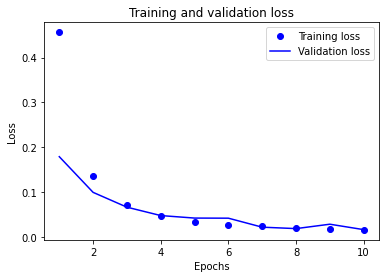

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

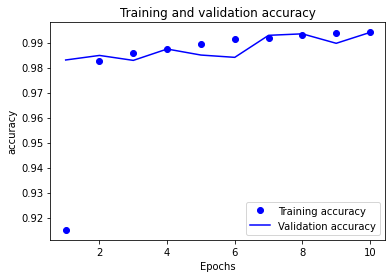

In [ ]:
plt.clf()
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
first_batch = val_data[0]  # get the first batch of data
first_element_in_first_batch = first_batch[0]

1/1 [==============================] - 3s 3s/step


Text(0.5, 1.0, 'Prediction')

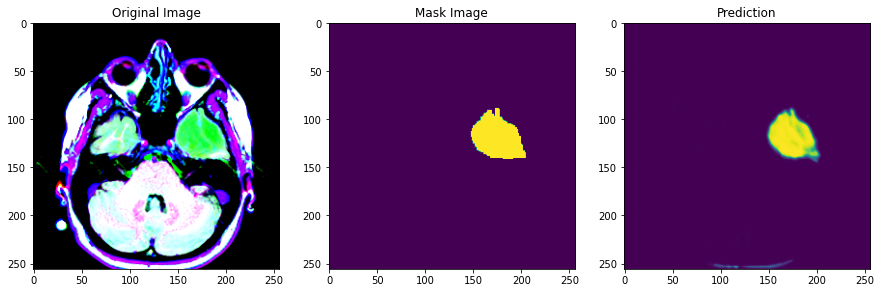

In [ ]:
# create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# get the first batch of data
first_batch = val_data[0]

# get the first element in the first batch
first_element = first_batch[0][0]

# plot the original image
axs[0].imshow(first_element)
axs[0].set_title('Original Image')

# plot the mask image
mask_image = first_batch[1][0,:,:,0]
axs[1].imshow(mask_image)
axs[1].set_title('Mask Image')

# use the model to make a prediction on the original image
prediction = model.predict(first_element.reshape(1, 256, 256, 3))

# plot the prediction
axs[2].imshow(prediction[0,:,:,0])
axs[2].set_title('Prediction')


